**Mask-RCNN using pre-trained COCO weights.**

Credits: https://www.kaggle.com/code/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155

### Note: 

After having run some simple codes in our system (which is not GPU enabled, and also Kaggle GPU seems more appropriate) we found out that the data given to us as a Google Drive file [https://drive.google.com/drive/folders/1GYAe8hZB8Si5YSW0akNXBpsELRicE4Hp] is EXACTLY the same as that is here: [https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge].

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd                                                 # for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clrity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('display.float_format', lambda x: '%.3f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration                                               
import seaborn as sns                                               # Importing seaborn library for interactive visualization
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline


#-------------------------------------------------------------------------------------------------------------------------------
import os 
import sys
import random
import math
import cv2
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import glob
from sklearn.model_selection import KFold

In [2]:
DATA_DIR = '../input/rsna-pneumonia-detection-challenge'
TRAIN_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
TEST_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'
TRAIN_LABELS = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'

#### Install Matterport's Mask-RCNN model from github.

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...

remote: Enumerating objects: 956, done.

remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956

Receiving objects: 100% (956/956), 119.41 MiB | 40.04 MiB/s, done.

Resolving deltas: 100% (569/569), done.


In [4]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


#### Download COCO pre-trained weights

In [6]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [7]:
SPLIT = 0.20 

In [10]:
#imageDataFromDirectory
class imageDataFromDirectory():
    
    def __init__(self, img_dir, img_list, parsed_dict=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.img_dir = img_dir
        self.img_list = img_list
        self.parsed_dict = parsed_dict
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.img_dir, filename)).pixel_array
        # create empty mask of the shape of input image
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.parsed_dict:
            # loop through pneumonia
            for location in self.parsed_dict[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.img_dir, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        img_list = self.img_list[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and img_list
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in img_list]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, img_list
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in img_list]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_list)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.img_list) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.img_list) / self.batch_size)

In [15]:
SPLIT = 0.20 
BATCH_SIZE = 16
IMG_SIZE = 224
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 42

In [16]:
import csv
#create parsed dict
parsed_dict = {}
with open(os.path.join(TRAIN_LABELS), mode='r') as labels_file:
    labels_file = csv.reader(labels_file)
    next(labels_file, None)
    for rows in labels_file:
        patientId = rows[0] #patientId
        b_box = rows[1:5] #[x,y,width,height] #bounding box information
        if_pneumonia = rows[5] #Target

        if if_pneumonia == '1':
            b_box = [int(float(i)) for i in b_box]

            if patientId in parsed_dict:
                parsed_dict[patientId].append(b_box)
            else:
                parsed_dict[patientId] = [b_box]
                
                
# load and shuffle img_list
img_list = os.listdir(TRAIN_DIR)
random.shuffle(img_list)

#train test split
num_total_samples = len(img_list)
split = SPLIT
num_val_samples = int(split*num_total_samples)
random.shuffle(img_list)

train_list = img_list[num_val_samples:]
val_list = img_list[:num_val_samples]


# create train and validation generators
train_dir = TRAIN_DIR
train_ds = imageDataFromDirectory(train_dir, train_list, parsed_dict, 
                                  batch_size=BATCH_SIZE, image_size=IMG_SIZE, 
                                  shuffle=True, augment=True, predict=False)
val_ds = imageDataFromDirectory(train_dir, val_list, parsed_dict, 
                                batch_size=BATCH_SIZE, image_size=IMG_SIZE, 
                                shuffle=False, predict=False)

In [17]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

#### Image Augmentation

In [18]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# MODEL Training

In [21]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Excluding the last layers because they require a matching number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [22]:
LEARNING_RATE = 0.006

In [23]:
%%time
model.train(train_ds, val_ds,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history



Starting at epoch 0. LR=0.012



Checkpoint Path: /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_{epoch:04d}.h5

Selecting layers to train

fpn_c5p5               (Conv2D)

fpn_c4p4               (Conv2D)

fpn_c3p3               (Conv2D)

fpn_c2p2               (Conv2D)

fpn_p5                 (Conv2D)

fpn_p2                 (Conv2D)

fpn_p3                 (Conv2D)

fpn_p4                 (Conv2D)

In model:  rpn_model

    rpn_conv_shared        (Conv2D)

    rpn_class_raw          (Conv2D)

    rpn_bbox_pred          (Conv2D)

mrcnn_mask_conv1       (TimeDistributed)

mrcnn_mask_bn1         (TimeDistributed)

mrcnn_mask_conv2       (TimeDistributed)

mrcnn_mask_bn2         (TimeDistributed)

mrcnn_class_conv1      (TimeDistributed)

mrcnn_class_bn1        (TimeDistributed)

mrcnn_mask_conv3       (TimeDistributed)

mrcnn_mask_bn3         (TimeDistributed)

mrcnn_class_conv2      (TimeDistributed)

mrcnn_class_bn2        (TimeDistributed)

mrcnn_mask_conv4       (TimeD

In [24]:
%%time
model.train(train_ds, val_ds,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]



Starting at epoch 2. LR=0.006



Checkpoint Path: /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_{epoch:04d}.h5

Selecting layers to train

conv1                  (Conv2D)

bn_conv1               (BatchNorm)

res2a_branch2a         (Conv2D)

bn2a_branch2a          (BatchNorm)

res2a_branch2b         (Conv2D)

bn2a_branch2b          (BatchNorm)

res2a_branch2c         (Conv2D)

res2a_branch1          (Conv2D)

bn2a_branch2c          (BatchNorm)

bn2a_branch1           (BatchNorm)

res2b_branch2a         (Conv2D)

bn2b_branch2a          (BatchNorm)

res2b_branch2b         (Conv2D)

bn2b_branch2b          (BatchNorm)

res2b_branch2c         (Conv2D)

bn2b_branch2c          (BatchNorm)

res2c_branch2a         (Conv2D)

bn2c_branch2a          (BatchNorm)

res2c_branch2b         (Conv2D)

bn2c_branch2b          (BatchNorm)

res2c_branch2c         (Conv2D)

bn2c_branch2c          (BatchNorm)

res3a_branch2a         (Conv2D)

bn3a_branch2a          (BatchNorm)

res3a_branch2b    

In [25]:
%%time
model.train(train_ds, val_ds,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]



Starting at epoch 6. LR=0.0012000000000000001



Checkpoint Path: /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_{epoch:04d}.h5

Selecting layers to train

conv1                  (Conv2D)

bn_conv1               (BatchNorm)

res2a_branch2a         (Conv2D)

bn2a_branch2a          (BatchNorm)

res2a_branch2b         (Conv2D)

bn2a_branch2b          (BatchNorm)

res2a_branch2c         (Conv2D)

res2a_branch1          (Conv2D)

bn2a_branch2c          (BatchNorm)

bn2a_branch1           (BatchNorm)

res2b_branch2a         (Conv2D)

bn2b_branch2a          (BatchNorm)

res2b_branch2b         (Conv2D)

bn2b_branch2b          (BatchNorm)

res2b_branch2c         (Conv2D)

bn2b_branch2c          (BatchNorm)

res2c_branch2a         (Conv2D)

bn2c_branch2a          (BatchNorm)

res2c_branch2b         (Conv2D)

bn2c_branch2b          (BatchNorm)

res2c_branch2c         (Conv2D)

bn2c_branch2c          (BatchNorm)

res3a_branch2a         (Conv2D)

bn3a_branch2a          (BatchNorm)

re

In [26]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.946854,0.031487,0.693769,0.214321,0.597003,0.410272,1.823529,0.027753,0.575787,0.267288,0.541263,0.411436
2,1.929175,0.023780,0.868914,0.200593,0.447650,0.388232,1.839756,0.025579,0.701061,0.238327,0.482655,0.392131
3,1.756589,0.024137,0.624220,0.271979,0.450950,0.385289,1.789226,0.022452,0.630046,0.262430,0.464801,0.409486
4,1.613158,0.015386,0.499803,0.253540,0.459370,0.385043,1.640905,0.020456,0.528593,0.247765,0.442707,0.401368
5,1.721350,0.021225,0.637577,0.265907,0.426047,0.370576,1.583750,0.018860,0.492725,0.236142,0.437181,0.398827
6,1.862439,0.020442,0.711252,0.294781,0.453607,0.382338,1.581114,0.017706,0.490512,0.247800,0.429457,0.395621
7,1.510706,0.017184,0.546795,0.183418,0.389289,0.374001,1.456361,0.014699,0.432355,0.228198,0.394621,0.386470
8,1.320470,0.011504,0.369017,0.181782,0.386946,0.371203,1.319434,0.012102,0.355022,0.204722,0.368766,0.378803
9,1.388407,0.013737,0.473610,0.166606,0.368889,0.365546,1.350969,0.012975,0.376266,0.198117,0.379924,0.383668
10,1.474691,0.014926,0.527488,0.183004,0.382210,0.367044,1.291200,0.011189,0.337158,0.200826,0.362751,0.379258


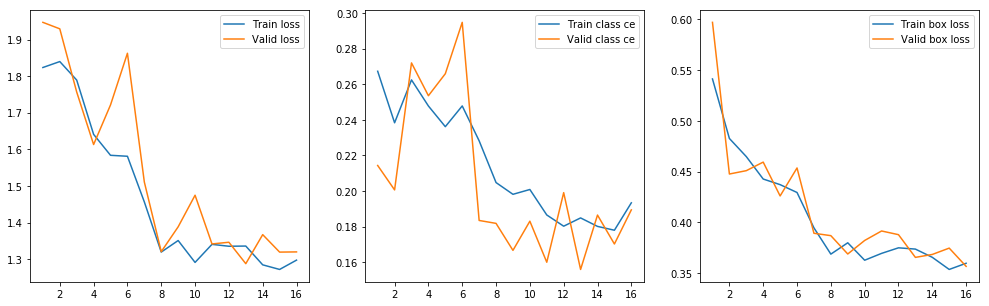

In [27]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [28]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 13 1.2877648568153381


In [29]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20190702T0812/mask_rcnn_pneumonia_0013.h5


1f1a0bd2-7589-442a-be91-3c284020fae7

[112  27 179  86]

x 108 y 448 h 236 w 268

[102 134 184 202]

x 536 y 408 h 272 w 328

1b92d9eb-97ec-4289-b4d4-b3383eb3d397

[123 152 168 217]

x 608 y 492 h 260 w 180

[120  67 157 102]

x 268 y 480 h 140 w 148

[ 59 131 120 183]

x 524 y 236 h 208 w 244

04bccc40-9a80-419a-9210-bd3c2114754b

[114  44 155  96]

x 176 y 456 h 208 w 164

[124 179 163 222]

x 716 y 496 h 172 w 156

[ 70 146 111 177]

x 584 y 280 h 124 w 164

21bd7ee7-584f-4b18-98ce-38a7b76b644d

[118  48 161  95]

x 192 y 472 h 188 w 172

[ 97 152 163 204]

x 608 y 388 h 208 w 264


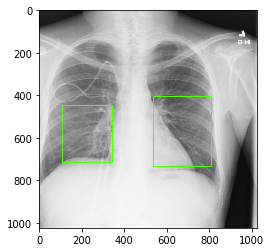

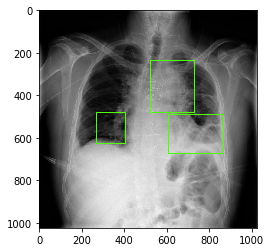

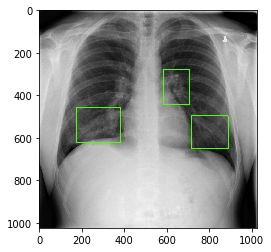

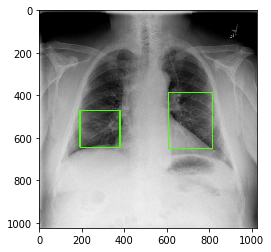

In [37]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(TEST_DIR)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

In [38]:
# remove files to allow committing (hit files limit otherwise)
!rm -rf /kaggle/working/Mask_RCNN